# Create a Machine Learning Model for Textual Topic Classification
Part 1 of 2
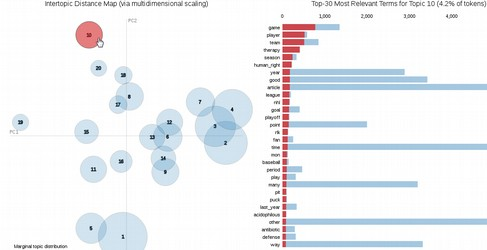
## Introduction

In this tutorial notebook we will use the <a href="https://radimrehurek.com/gensim/about.html" target="_blank" rel="noopener noreferrer">gensim</a> library to create a <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" target="_blank" rel="noopener noreferrer">Latent Dirichlet allocation (LDA)</a> machine learning <a href="https://en.wikipedia.org/wiki/Topic_model" target="_blank" rel="noopener noreferrer">topic model</a>. LDA is an _unsupervised_ model, which means that the data is _unlabeled_ and nothing is really known about the documents before-hand. The training of the model will attempt to infer from the corpus (body of training documents) what the major _topics_ are. By default, twenty topics will be identified. Each topic is assigned a number and consists of a collection of words coupled with the weight of that word within the topic.

There are many uses for unsupervised topic modeling when dealing with the massive amount of social media flooding the web. In our example, we will attempt to assign a subject category to documents submitted to various newsgroup forums. We will use a sample newsgroup dataset <a href="https://rare-technologies.com/new-api-for-pretrained-nlp-models-and-datasets-in-gensim/" target="_blank" rel="noopener noreferrer">provided by gensim</a> for the purposes of training and testing. RaRe Technologies <a href="https://github.com/RaRe-Technologies/gensim-data#available-data" target="_blank" rel="noopener noreferrer">describes</a> the __20-newsgroup__ dataset as: _The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups._

Assigning an LDA topic to a document would not provide much insight into the document's subject category, since it is just a number with a collection of terms. Rather, we will use the training data's newsgroup name to find a _typical_ pattern of topic probability. We'll do this by re-reading the data and using the trained model to find the probability for each topic being a good match for the document. This will give a vector (1 to 20) of probabilities. Then a vector mean is used for each newsgroup to provide a single topic probability vector for that newsgroup. When new documents are analyzed with the model, the resulting topic probability vector can be compared against each newsgroup's vector. By using the euclidean distance similarity method, we can find the closest match between a document's topic probability vector and the newsgroup's vector.  

Since there is a lot of overlap in the terms used by different newsgroups, we've provided a (python) dictionary to map several newsgroups to the subject categories that we want to identify.
***
This is Part 1 of this tutorial notebook series, where we will perform the following tasks:
* Create and train the model
* Visualize the model with <a href="http://pyldavis.readthedocs.io/en/latest/" target="_blank" rel="noopener noreferrer">pyLDAvis</a>
* Compute the typical topic probability vector for each newsgroup
* Save the model and other objects to __IBM Cloud Object Storage__.
* Test the accuracy of our model and the method of identifying the documents' subject category
***
<font color=red>**UPDATE LINK!!!**</font>  
In [Part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee), we will create a __streams flow__ using __IBM Streams Designer__, that uses the model to perform real-time topic classification on streaming news items to identify their subject category.

Some familiarity with Python is recommended. This notebook has been verified for Python 3.5, Spark 2.1 and gensim 2.2.

## <a id="TOC"></a> Table of contents
1. [Setup](#setup)<br>
    1.1 [Install prerequisite packages (once) and load libraries](#setup1)<br>
    1.2 [Download the sample dataset](#setup2)<br>
    1.3 [Provide details for Cloud Object Storage (COS)](#setup3)<br>
2. [Prepare the dataset](#dataset)<br>
3. [Create the model](#train)<br>
4. [Display the topic model visualization](#visualize)<br>
5. [Topic probability for each newsgroup](#probability)<br>
6. [Save the model and other objects to Cloud Object Storage](#save)<br>
7. [Test topic model accuracy](#test)<br>
8. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. [Setup](#TOC)

<a id="setup1"></a>
### 1.1 [Install prerequisite packages (once) and load libraries](#TOC)
Make sure that these packages are installed in your environment. (This only needs to be run once.)

Notice that we are installing gensim version 2.2, which is not the latest version, but it is recommended since it is the version installed on the _IBM Cloud Streaming Analytics_ service environment at the time this notebook was tested.

In [ ]:
!pip install nltk
!pip install pandas==0.19.2
!pip install gensim==2.2
!pip install pyLDAvis

# RESTART kernel

If you ran the `pip install` commands above <font color=red>**RESTART**</font> the notebook kernel. From the notebook menu above, select **Kernel -> Restart and Clear Output**.

**Import the libraries**  
**After the restart**, continue here with the import of the libraries. This step verifies that they were installed and that you restarted the kernel.

In [1]:
from gensim import utils, models
import pyLDAvis.gensim
import numpy
import re

Using TensorFlow backend.


**[Optional] Setup logging and warning levels**  
Ignore deprecation warnings.  
Set the logging level to display more or fewer messages. The gensim library provides many interesting progress messages. The default here is to display only errors.
* Change the default level to _logging.INFO_ to see the messages. Valid levels are: _CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET_
* You can change the level at any time with these commands:
```
logger = logging.getLogger()
logger.setLevel(logging.INFO)
```

In [2]:
# Optional: Set the default logging level.
import logging
logging.basicConfig( level=logging.ERROR, format='%(asctime)s : %(name)s.%(funcName)s : %(levelname)s : %(message)s')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**Import the NLTK library and download the pre-trained Part-of-Speech Tagger and WordNet Lemmatizer**  
You can find more details about these functions in the [function: preprocess_text](#preprocess_text).

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nltk.download("wordnet")
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /gpfs/fs01/user/sca9-7277eb31
[nltk_data]     bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to /gpfs/fs
[nltk_data]     01/user/sca9-7277eb31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /gpfs/fs01/user/sca9-7277eb
[nltk_data]     31bca08b-bc196c953de3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="setup2"></a>
### 1.2 [Download the sample dataset](#TOC)
As mentioned, we are using gensim version 2.2, but we can use <a href="https://github.com/RaRe-Technologies/gensim/blob/master/gensim/downloader.py" target="_blank" rel="noopener noreferrer">the code</a> from the latest version, described <a href="https://radimrehurek.com/gensim/downloader.html" target="_blank" rel="noopener noreferrer">here</a>, to grab our dataset directly from the gensim github repository.

In [4]:
DOWNLOAD_BASE_URL = "https://github.com/RaRe-Technologies/gensim-data/releases/download"
dataset="20-newsgroups"

![[ ! -f {dataset}.gz ]] && wget '{DOWNLOAD_BASE_URL}/{dataset}/{dataset}.gz'
!pwd; ls -l {dataset}.gz*

/gpfs/fs01/user/sca9-7277eb31bca08b-bc196c953de3/notebook/work
-rw------- 1 sca9-7277eb31bca08b-bc196c953de3 users 14483581 Nov  9 17:44 20-newsgroups.gz


<a id="setup3"></a>
### 1.3 [Provide details for Cloud Object Storage (COS)](#TOC)
You will need to open the [IBM Cloud Dashboard](https://console.bluemix.net/dashboard/) to retrieve information about your __Cloud Object Storage__ service.
* Select the `Service credentials` pane on left. Click `View credentials` on one of your credentials, and then copy it.
  * You can replace the entire content of the **cos_credentials** variable below with your credentials, or provide only your <font color=blue>apikey</font> and rely on the defaults used in the **save_to_cos** function.  
  * Make sure that the <font color=red>_name_</font> of the credentials variable is set to **cos_credentials**.
---
* On the `Buckets and objects` page, choose an existing bucket or create one by clicking &oplus;__Create bucket__.
  * Modify the **model_bucket_name** variable below with the bucket you chose.
  * You can also modify the name of the object (file) which will be created in that bucket.

In [5]:
cos_credentials = {
  "apikey": "<REPLACE>"
}

In [6]:
model_bucket_name = 'pyml'
model_object_name = 'news.lda_model.pkg.gz'

<a id="dataset"></a>
## 2. [Prepare the dataset](#TOC)

### [function: read_dataset](#TOC)
This function reads the input dataset file. The input is in JSON format, with a property called `topic` (not to be confused with the LDA topic) for the newsgroup name, and another called `data` for the submitted text documents.

Parameters:
* dataset_path: Path and filename of the dataset file.
* max_lines: If greater than 0, read only max_lines number of lines.

Returns:
* output: A dictionary of newsgroups, each with a list of all its texts.

In [7]:
def read_dataset(dataset_path, max_lines=0):
    from smart_open import smart_open
    import json

    print("opening...", dataset_path)
    
    output = {}
    n = 0
    with smart_open( dataset_path, 'rb') as infile:
        for n, line in enumerate(infile):
            if max_lines > 0 and n == max_lines: break
            jsonData = json.loads(line.decode('utf8'))
            # Input dataset JSON elements to extract
            newsgroup = jsonData['topic']
            text = jsonData['data']
            # Output dataset format: {'newsgroup1':['text1','text2',...], 'newsgroup2':...}
            if output.get(newsgroup) == None: output[newsgroup] = []
            output[newsgroup].append(text)

    print(n, "texts read, from", len(output), "newsgroups")

    return output

### [function: split_dataset](#TOC)
This function splits the text lists of each newsgroup into a list for training and for testing.

Parameters:
* input_dataset: The newsgroup dictionary (as returned by read_dataset()).
* split_ratio: A float between 0 and 1, indicating the percent of texts to use for training.

Returns:
* training, testing: Two dictionaries like the input_dataset, but with the text lists split by the split_ratio.

In [8]:
def split_dataset(input_dataset, split_ratio):
    training = {}
    testing = {}

    for ng in sorted(input_dataset):
        train_qty = int(len(input_dataset[ng]) * split_ratio)
        training[ng] = input_dataset[ng][:train_qty]
        testing[ng] = input_dataset[ng][train_qty:]

    print("Train",len(sum(training.values(),[])),"texts")
    
    return training, testing

### [Prepare the dataset](#TOC)

Read the dataset.

In [9]:
newsgroup_dataset = read_dataset(dataset+".gz")

opening... 20-newsgroups.gz
18845 texts read, from 20 newsgroups


Split the dataset for training and testing.

In [10]:
newsgroup_training, newsgroup_testing = split_dataset(newsgroup_dataset, 0.70)

Train 13184 texts


<a id="train"></a>
## 3. [Create the model](#TOC)

<a id="preprocess_text"></a>
### [function: preprocess_text](#TOC)
This function does the following steps to preprocess and cleanse texts:
1. The following text and symbols are removed by using regular expression substitution:
   * Email addresses (with @)
   * Punctuaton marks: .,?!:;()[]{}\-<>=
   * Lines with heading fields: From, Organization, X-Newsreader, etc.
   * Heading field word _Subject:_
2. The text is converted to lowercase, accent marks removed, and then tokenized.
3. Some noun derivatives and adjectives are retained (others are discarded) by using a Part-of-Speech tagger (from NLTK).
   (By the way, this method was found to be more effective for identifying the topic/category of a newsgroup, rather than simply removing stop words.)
4. Words of 1 or 2 characters are discarded.
5. Lemmatize words in their verb and noun forms.

Parameters:
* text: A single text entry from a newsgroup.
* lemmatizer: A lemmatizer (For details, see <a href="http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer" target="_blank" rel="noopener noreferrer">NLTK WordNetLemmatizer()</a>).    
* pos_tagger: A Part-of-Speech tagger (For details, see <a href="http://www.nltk.org/api/nltk.tag.html?highlight=pos_tag#nltk.tag.pos_tag" target="_blank" rel="noopener noreferrer">NLTK provides an off-the-shelf tagger for English which uses the Penn Treebank tagset</a>).    

Returns:
* tokens: Preprocessed tokenized texts.

In [11]:
def preprocess_text(text, lemmatizer, pos_tagger):

    text = re.sub(r'(?i)[^@ ]*@[^@ ]*', ' ', text)
    text = re.sub(r'(?i)((From|Reply-To|Organization|Lines|Nntp-Posting-Host|X-Newsreader): [^\n]*\n)|(Subject: (re: )*)', ' ', text)
    text = re.sub(r'(?i)([.,?!:;()\[\]{}\-<>=$\\]+)|(_){2,}', ' ', text)

    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos='n'), pos='v')
                for word,wordtype in pos_tagger(
                    [tok for tok in utils.tokenize(text, lowercase=True, deacc=True, errors="ignore") if len(tok) > 2]) 
                if wordtype in ['NN','NNS','NNP','JJ']]

    return tokens

### [function: train_model](#TOC)
Steps to create the model:
1. Create a Dictionary by using the List of cleansed tokenized text.
2. [optional] Filter extremes. The example would filter out tokens which are in less than 10 and more than 75.0% of the documents. Adjust to your needs.
3. Create a corpus from the Bag-of-Words method.  
    The BOW method takes the text tokens (words) and returns a list of tuples containing the word's token-id within the dictionary, and it's frequency within the input text.
4. Create and train an LDA model. Adjust the hyperparameters to affect speed and quality.   
    For example, for higher quality increase `iterations` and `passes`.   
    For lower quality but faster execution, set `iterations=10, passes=1`.

Parameters:
* textTokens: List of cleansed documents, where each document is represented by a List of tokens.

Results:
* model: The trained LDA model.
* dictionary: The dictionary created from the tokenized text.
* textBOW: The corpus used in creating the model.

In [12]:
def train_model(textTokens):
    from gensim import corpora, models

    dictionary = corpora.Dictionary( documents=textTokens)
    
    # Optional: Filter out tokens which are in less than 10 and more than 75.0% of the documents
    # dictionary.filter_extremes(no_below=10, no_above=0.75, keep_n=50000)

    textBOW = [dictionary.doc2bow(text) for text in textTokens]

    model = models.ldamodel.LdaModel( corpus=textBOW, id2word=dictionary,
                                      num_topics=20, update_every=0.5,
                                      iterations=25, passes=3)

    return model, dictionary, textBOW

### [Create the model](#TOC)

### Preprocess the training texts
Save each document's token-list within a list for each newsgroup in the *newsgroup_tokens* dictionary.

In [13]:
%%time
newsgroup_tokens = {}

print("Processing newsgroup: ")
for n,ng in enumerate(sorted(newsgroup_training)):
    print("{}:{}({})...".format((n+1), ng, len(newsgroup_training[ng])), end=" ")
    newsgroup_tokens[ng] = []
    for text in newsgroup_training[ng]:
        newsgroup_tokens[ng].append(preprocess_text(text, lemmatizer, nltk.pos_tag))

Processing newsgroup: 
1:alt.atheism(559)... 2:comp.graphics(681)... 3:comp.os.ms-windows.misc(689)... 4:comp.sys.ibm.pc.hardware(687)... 5:comp.sys.mac.hardware(674)... 6:comp.windows.x(691)... 7:misc.forsale(682)... 8:rec.autos(693)... 9:rec.motorcycles(697)... 10:rec.sport.baseball(695)... 11:rec.sport.hockey(699)... 12:sci.crypt(693)... 13:sci.electronics(688)... 14:sci.med(693)... 15:sci.space(690)... 16:soc.religion.christian(697)... 17:talk.politics.guns(637)... 18:talk.politics.mideast(658)... 19:talk.politics.misc(542)... 20:talk.religion.misc(439)... CPU times: user 3min 52s, sys: 2.31 s, total: 3min 55s
Wall time: 3min 55s


Now that we have the tokens from all the documents, create a bigram phraser to identify common word pairs.

In [14]:
%%time
bigram = models.Phrases(sum(newsgroup_tokens.values(),[]))
bigram_phraser = models.phrases.Phraser(bigram)

CPU times: user 8.54 s, sys: 143 ms, total: 8.68 s
Wall time: 8.67 s


Replace the paired tokens, such as ('united','states'), with the bigram token ('united_states').

In [15]:
%%time
for ng in newsgroup_tokens:
    print("{:25} Tokens: {}".format(ng,len(sum(newsgroup_tokens[ng],[]))), end=" ")
    newsgroup_tokens[ng] = [bigram_phraser[tokens] for tokens in newsgroup_tokens[ng]]
    print("==> {}".format(len(sum(newsgroup_tokens[ng],[]))))

rec.sport.baseball        Tokens: 46654 ==> 42232
sci.crypt                 Tokens: 84275 ==> 73337
talk.religion.misc        Tokens: 46401 ==> 42926
comp.sys.mac.hardware     Tokens: 40052 ==> 36312
misc.forsale              Tokens: 37053 ==> 33377
alt.atheism               Tokens: 56865 ==> 52307
sci.electronics           Tokens: 44169 ==> 40497
talk.politics.misc        Tokens: 73107 ==> 65268
rec.sport.hockey          Tokens: 64214 ==> 57566
rec.autos                 Tokens: 44977 ==> 41180
rec.motorcycles           Tokens: 41626 ==> 37529
comp.windows.x            Tokens: 69360 ==> 62495
talk.politics.guns        Tokens: 70786 ==> 62775
comp.graphics             Tokens: 54953 ==> 49961
talk.politics.mideast     Tokens: 104788 ==> 93958
sci.space                 Tokens: 71118 ==> 64723
soc.religion.christian    Tokens: 78004 ==> 73064
comp.sys.ibm.pc.hardware  Tokens: 42738 ==> 37788
comp.os.ms-windows.misc   Tokens: 41519 ==> 37597
sci.med                   Tokens: 65768 ==> 60162

### Train the model
Use the tokens from all the newsgroups.

In [16]:
%%time 
model, dictionary, corpus = train_model( sum(newsgroup_tokens.values(),[]))

CPU times: user 3min 19s, sys: 8min 41s, total: 12min 1s
Wall time: 3min 49s


<a id="visualize"></a>
## 4. [Display the topic model visualization](#TOC)

You can print some of the terms which make up the model topics. In the following code, only 5 of the 20 topics and 8 terms for each topic are printed. Each term is coupled with its relative weight within the topic.

In [17]:
for tt in sorted(model.print_topics(num_topics=-1, num_words=8))[:5]:
    print("Topic={}, Terms={}...".format(tt[0],tt[1]), end="\n\n")

Topic=0, Terms=0.020*"people" + 0.011*"christian" + 0.008*"law" + 0.007*"church" + 0.007*"god" + 0.007*"jesus" + 0.006*"right" + 0.006*"other"...

Topic=1, Terms=0.018*"armenian" + 0.008*"war" + 0.007*"turkish" + 0.006*"arab" + 0.006*"russian" + 0.005*"jew" + 0.005*"country" + 0.005*"german"...

Topic=2, Terms=0.009*"april" + 0.008*"university" + 0.007*"information" + 0.007*"center" + 0.007*"mission" + 0.006*"year" + 0.006*"new_york" + 0.005*"program"...

Topic=3, Terms=0.012*"data" + 0.010*"system" + 0.009*"keyboard" + 0.007*"information" + 0.007*"key" + 0.006*"available" + 0.005*"package" + 0.005*"mail"...

Topic=4, Terms=0.014*"year" + 0.010*"game" + 0.008*"time" + 0.008*"good" + 0.006*"day" + 0.006*"part" + 0.006*"first" + 0.006*"article"...



We can use the **pyLDAvis** package to investigate the topic model. For details about the package, see http://pyldavis.readthedocs.io/en/latest/ and https://github.com/bmabey/pyLDAvis.

When the display is ready, you can use the interactive visualization to explore the dominant terms of the topics.

In [18]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare( model, corpus, dictionary)

pyLDAvis.display(vis)

<a id="probability"></a>
## 5. [Topic probability for each newsgroup](#TOC)

### [function: get_topic_probability_list](#TOC)
Given a tokenized text, use the LDA model to return a list with the probability for each topic.  
By setting `minimum_probability=0` in the *get_document_topics()* function, a complete list of topics is returned, even if the probability is zero. This assures a constant _shape_ for the array to equal the number of topics in the model.

Parameters:
* model: The trained LDA model
* textTokens: A List of tokens

Results:
* topicList: A list of probabilities. The position in the list corresponds to the topic id number.

In [19]:
def get_topic_probability_list(model, textTokens):

    topicList = []

    textBOW = model.id2word.doc2bow(textTokens)

    topicTuples = model.get_document_topics(textBOW, minimum_probability=0)

    topicList = list(list(zip(*topicTuples))[1])

    return topicList

### [Topic probability for each newsgroup](#TOC)

Calculate the mean of all the topic probability lists for each newsgroup. This should provide a sort of _typical topic probability pattern_ for the newsgroup.  
When we want to find the newsgroup/category for a new news document, we will compare (using a similarity matrix) the topic probability list returned by the model to each of these mean topic probabilities to find the closest matching newsgroup.

In [20]:
%%time
newsgroup_mean_topics = {}

print("Processing newsgroup:", end=" ")
for n,ng in enumerate(sorted(newsgroup_tokens)):
    print("{}:{}({})...".format((n+1), ng, len(newsgroup_testing[ng])), end=" ")

    newsgroup_topics = []
    for tokens in newsgroup_tokens[ng]:
        newsgroup_topics.append(get_topic_probability_list(model, tokens))

    newsgroup_mean_topics[ng] = numpy.mean(newsgroup_topics, axis=0)

Processing newsgroup: 1:alt.atheism(240)... 2:comp.graphics(292)... 3:comp.os.ms-windows.misc(296)... 4:comp.sys.ibm.pc.hardware(295)... 5:comp.sys.mac.hardware(289)... 6:comp.windows.x(297)... 7:misc.forsale(293)... 8:rec.autos(297)... 9:rec.motorcycles(299)... 10:rec.sport.baseball(299)... 11:rec.sport.hockey(300)... 12:sci.crypt(298)... 13:sci.electronics(296)... 14:sci.med(297)... 15:sci.space(297)... 16:soc.religion.christian(300)... 17:talk.politics.guns(273)... 18:talk.politics.mideast(282)... 19:talk.politics.misc(233)... 20:talk.religion.misc(189)... CPU times: user 1min 15s, sys: 8min 32s, total: 9min 48s
Wall time: 1min 59s


Print the newsgroup mean topic probability lists.

In [21]:
for ng in sorted(newsgroup_mean_topics):
    print("{:25}:".format(ng), end=" ")
    for topic_prob in newsgroup_mean_topics[ng]:
        print("{:.3f}".format(topic_prob), end=" ")
    print("")

alt.atheism              : 0.274 0.026 0.007 0.007 0.015 0.110 0.027 0.014 0.015 0.021 0.022 0.015 0.012 0.035 0.046 0.290 0.019 0.016 0.006 0.022 
comp.graphics            : 0.016 0.018 0.030 0.134 0.026 0.031 0.017 0.022 0.015 0.028 0.049 0.018 0.051 0.010 0.014 0.042 0.007 0.453 0.006 0.015 
comp.os.ms-windows.misc  : 0.009 0.008 0.034 0.065 0.035 0.023 0.012 0.017 0.014 0.040 0.036 0.010 0.037 0.010 0.007 0.021 0.008 0.584 0.008 0.022 
comp.sys.ibm.pc.hardware : 0.007 0.005 0.016 0.050 0.020 0.026 0.019 0.037 0.008 0.075 0.087 0.007 0.021 0.008 0.009 0.020 0.010 0.543 0.008 0.022 
comp.sys.mac.hardware    : 0.010 0.005 0.020 0.053 0.016 0.045 0.057 0.037 0.005 0.090 0.077 0.010 0.017 0.010 0.011 0.028 0.006 0.466 0.006 0.031 
comp.windows.x           : 0.011 0.010 0.022 0.163 0.018 0.020 0.018 0.014 0.016 0.027 0.028 0.011 0.028 0.008 0.010 0.028 0.030 0.526 0.004 0.008 
misc.forsale             : 0.011 0.012 0.031 0.064 0.042 0.029 0.029 0.059 0.010 0.063 0.201 0.016 0.108 0.012 0

### Group the newsgroups into categories
Because many of the newsgroups share similar terminologies, we will be using our LDA model to classify new documents into broader categories.
Here is a dictionary which maps each newsgroup to a category.

In [22]:
# first print ng's
newsgroup_category = {
    'alt.atheism':             'religion',
    'comp.graphics':           'computers',
    'comp.os.ms-windows.misc': 'computers',
    'comp.sys.ibm.pc.hardware':'computers',
    'comp.sys.mac.hardware':   'computers',
    'comp.windows.x':          'computers',
    'misc.forsale':            'computers',
    'rec.autos':               'autos',
    'rec.motorcycles':         'autos',
    'rec.sport.baseball':      'sports',
    'rec.sport.hockey':        'sports',
    'sci.crypt':               'computers',
    'sci.electronics':         'computers',
    'sci.med':                 'computers',
    'sci.space':               'computers',
    'soc.religion.christian':  'religion',
    'talk.politics.guns':      'politics',
    'talk.politics.mideast':   'politics',
    'talk.politics.misc':      'politics',
    'talk.religion.misc':      'religion'
}

<a id="save"></a>
## 6. [Save the model and other objects to Cloud Object Storage](#TOC)

### [function: bundle_package](#TOC)
Pickle (serialize) and compress a dictionary. Add a key-value to the dictionary for the current timestamp.

Parameters:
* pkg: A dictionary object.

Results:
* timestamp: The package creation timestamp.
* pkg_gz: The compressed package.

In [23]:
def bundle_package(pkg):
    import pickle, gzip
    from time import strftime

    timestamp = strftime('%Y-%m-%d_%H.%M.%S')

    pkg['timestamp'] = timestamp

    pkg_gz = gzip.compress(pickle.dumps(pkg))
    
    return timestamp, pkg_gz

### [function: save_to_cos](#TOC)
Save an object to Cloud Object Storage (COS) using the REST API.

Parameters:
* cred: Dictionary of COS credentials. It may contain various key names, depending on where the credentials were copied from.
* bucket_name: COS bucket_name (must already exist!)
* object_name: Name of object to write.
* data: Serialized data to write.

In [24]:
def save_to_cos(cred, bucket_name, object_name, data):
    import requests

    default_iam_url = 'https://iam.ng.bluemix.net/oidc/token'
    default_endpoint = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'
    
    api_key = cred.get('apikey', cred.get('api_key', cred.get('IBM_API_KEY_ID')))
    iam_url = cred.get('iam_url', cred.get('IBM_AUTH_ENDPOINT', default_iam_url))
    endpoint = cred.get('url', cred.get('ENDPOINT', default_endpoint))

    if not api_key:
        print("ERROR: Missing api key")
        return

    full_object_path = bucket_name + "/" + object_name
    print("Saving", full_object_path, "(", str(len(data)), "bytes)")

    response = requests.post(
                url = iam_url,
                headers = {"Content-Type": "application/x-www-form-urlencoded"},
                params = {"grant_type":"urn:ibm:params:oauth:grant-type:apikey","apikey":api_key},
                verify = True)
    if response.status_code != 200:
        print( "ERROR: POST Response =", response.status_code, response.reason, response.text)
        return
    bearer_token = response.json()["access_token"]
    
    response = requests.put(
                url = endpoint + "/" + full_object_path,
                headers = {"Authorization": "bearer " + bearer_token},
                data = data)    
    if response.status_code != 200:
        print( "ERROR: PUT Response =", response.status_code, response.reason, response.text)

### [Save the model and other objects to Cloud Object Storage](#TOC)
* Package the model, bigram phraser, mean topic dict and newsgroup category dict into a dictionary object, which can be serialized and compressed to a single object.
* Save the object to COS.

In [25]:
ts, pkg_gz = bundle_package({ 
    'model': model,
    'phraser': bigram_phraser,
    'newsgroup_mean_topics': newsgroup_mean_topics,
    'newsgroup_category': newsgroup_category
})
print("Packaged {}: {} bytes; creation timestamp: {}".format(model_object_name, len(pkg_gz), ts))

Packaged news.lda_model.pkg.gz: 14707376 bytes; creation timestamp: 2018-02-07_07.17.32


In [26]:
save_to_cos( cos_credentials, model_bucket_name, model_object_name, pkg_gz)

Saving pyml/news.lda_model.pkg.gz ( 14707376 bytes)


<a id="test"></a>
## 7. [Test topic model accuracy](#TOC)

### [function: closest_newsgroup](#TOC)
Determine the closest matching newsgroup by finding the shortest euclidean distance between the document's _topic probability vector_ and the vector for each newsgroup.

Parameters:
* mean_topics: A List of topic probability vectors for each newsgroup.
* topics: A topic probability vector (List) for a single document.

Results:
* The index of the newsgroup with the shortest distance

In [27]:
def closest_newsgroup(mean_topics, topics):
    distances = {}

    for ng in mean_topics.keys():
        distances[ng] = numpy.linalg.norm(mean_topics[ng] - topics)

    return min(distances, key=distances.get)

### [Test topic model accuracy](#TOC)
Let's use the slice of the dataset which we reserved for testing to check the accuracy of our ability to choose the category of the text. These steps mimic those which will be taken by the real-time classification in the streams flow described in [Part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee).
<font color=red>**UPDATE LINK!!!**</font>  

In [28]:
%%time
correct = 0
cnt = 0
testing_tokens = {}

for n,ng in enumerate(sorted(newsgroup_testing)):
    print("Processing newsgroup: {:02d}:{:25} ({})...".format((n+1), ng, len(newsgroup_testing[ng])), end=" ")
    cat_correct = 0
    testing_tokens[ng] = []
    for text_cnt,text in enumerate(newsgroup_testing[ng]):

        tokens = preprocess_text(text, lemmatizer, nltk.pos_tag)
        tokens = bigram_phraser[tokens]
        testing_tokens[ng].append(tokens)

        topics = get_topic_probability_list(model, tokens)

        top_cat = newsgroup_category.get( closest_newsgroup(newsgroup_mean_topics, topics))

        cnt += 1
        if top_cat == newsgroup_category[ng]:
            correct += 1
            cat_correct += 1

    print(" {:10} Accuracy: {:.5f}".format(newsgroup_category[ng], float(cat_correct/text_cnt)))

print("\nOverall Accuracy:", float(correct/cnt), "\n")

Processing newsgroup: 01:alt.atheism               (240)...  religion   Accuracy: 0.74895
Processing newsgroup: 02:comp.graphics             (292)...  computers  Accuracy: 0.96564
Processing newsgroup: 03:comp.os.ms-windows.misc   (296)...  computers  Accuracy: 0.97966
Processing newsgroup: 04:comp.sys.ibm.pc.hardware  (295)...  computers  Accuracy: 0.98980
Processing newsgroup: 05:comp.sys.mac.hardware     (289)...  computers  Accuracy: 0.97569
Processing newsgroup: 06:comp.windows.x            (297)...  computers  Accuracy: 0.98311
Processing newsgroup: 07:misc.forsale              (293)...  computers  Accuracy: 0.85959
Processing newsgroup: 08:rec.autos                 (297)...  autos      Accuracy: 0.83784
Processing newsgroup: 09:rec.motorcycles           (299)...  autos      Accuracy: 0.61074
Processing newsgroup: 10:rec.sport.baseball        (299)...  sports     Accuracy: 0.80201
Processing newsgroup: 11:rec.sport.hockey          (300)...  sports     Accuracy: 0.89632
Processing

<a id="summary"></a>
## 8. [Summary and next steps](#TOC)

<font color=red>**UPDATE LINK!!!**</font>  

You have now trained an LDA model and used it to create a topic probability vector for each newsgroup. In our testing, this method provides greater than 80% accuracy to correctly identify the subject category of the news document. We then saved the LDA model, bigram phraser, mean topic dictionary and newsgroup category dictionary to Cloud Object Storage, ready to be used in [Part 2](https://dataplatform.ibm.com/analytics/notebooks/v2/abf17c29-ff75-4b59-a67c-411eda75e547/view?access_token=d82dd17f147bce9084bda230a4243133ab3f27cd29baf3a0fad750e7e03e3aee) of this tutorial. In Part 2, we will create a __streams flow__ by using __Streams Designer__ to perform real-time topic classification of new news documents.

### <a id="authors"></a>Authors
**Raanon Reutlinger** is a Developer at IBM Cloud Platform, Developer Services, working on the __Streams Designer__ IBM Cloud service. Raanon has over 20 years of experience in the IBM Software Group, working in Data Management, Big Data, and Watson teams.
<hr>
Copyright &copy; IBM Corp. 2017,2018. This notebook and its source code are released under the terms of the MIT License.